In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, roc_curve)
from sklearn.preprocessing import LabelEncoder
import warnings
import gc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import features_selection as fs

# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)
warnings.filterwarnings('ignore')

In [14]:
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

In [15]:
train_x,train_y,test_x,features = fs.process_features(train, test, label)

In [16]:
# 设置随机种子，保证结果可复现
np.random.seed(42)

# 假设train_x（DataFrame或数组）和train_y（Series或数组）是已有的训练数据
# 请确保在实际使用时已经正确加载了这两个变量

# 确保train_y是一维数组
if isinstance(train_y, pd.Series):
    train_y = train_y.values

# 获取特征数量和特征名称
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]

In [5]:
# 1. 定义多组不同的LightGBM参数配置（用于投票模型）
def get_lgb_param_sets():
    return [
        # 第一组参数
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'seed': 42,
            'n_jobs': -1
        },
        # 第二组参数
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.03,
            'num_leaves': 63,
            'max_depth': 8,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'bagging_freq': 3,
            'verbose': 0,
            'seed': 43,
            'n_jobs': -1
        },
        # 第三组参数
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.1,
            'num_leaves': 25,
            'max_depth': 6,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 7,
            'verbose': 0,
            'seed': 44,
            'n_jobs': -1
        },
        # 第四组参数
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'drop_rate': 0.1,
            'verbose': 0,
            'seed': 45,
            'n_jobs': -1
        }
    ]


In [6]:
# 2. 实现投票集成模型
def voting_ensemble(X, y, n_splits=5):
    param_sets = get_lgb_param_sets()
    print(f"将使用{len(param_sets)}个不同参数配置的LightGBM模型进行投票集成")
    
    # 训练所有基模型
    models = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    print("开始训练基模型...")
    for i, params in enumerate(param_sets, 1):
        # 交叉验证训练单个模型
        oof_preds = np.zeros(X.shape[0])
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            if isinstance(X, pd.DataFrame):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            else:
                X_train, X_val = X[train_idx], X[val_idx]
            
            y_train, y_val = y[train_idx], y[val_idx]
            
            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
            
            model = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_val],
                early_stopping_rounds=50,
                verbose_eval=0
            )
            
            oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
            
            # 只保留最后一折的模型用于最终预测
            if fold == kf.n_splits - 1:
                models.append(model)
        
        # 评估该模型的OOF性能
        auc = roc_auc_score(y, oof_preds)
        print(f"基模型 {i} 交叉验证AUC: {auc:.4f}")
    
    return models, param_sets

# 3. 训练投票集成模型
models, param_sets = voting_ensemble(train_x, train_y)

将使用4个不同参数配置的LightGBM模型进行投票集成
开始训练基模型...
基模型 1 交叉验证AUC: 0.7252
基模型 2 交叉验证AUC: 0.7269
基模型 3 交叉验证AUC: 0.7233
基模型 4 交叉验证AUC: 0.7244


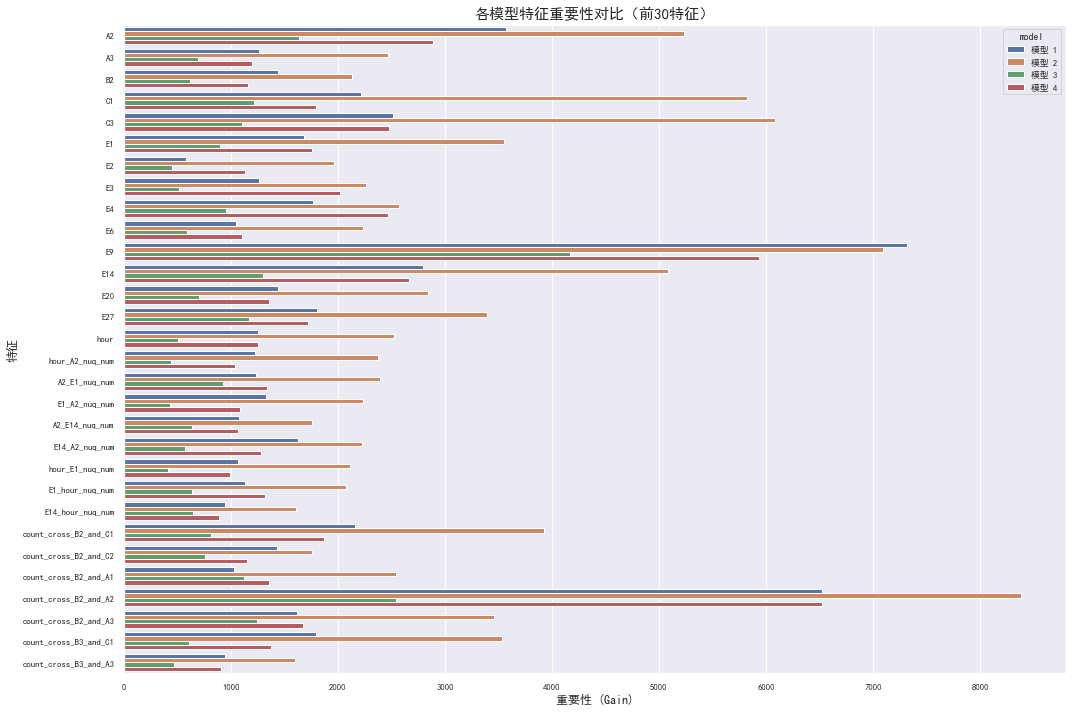

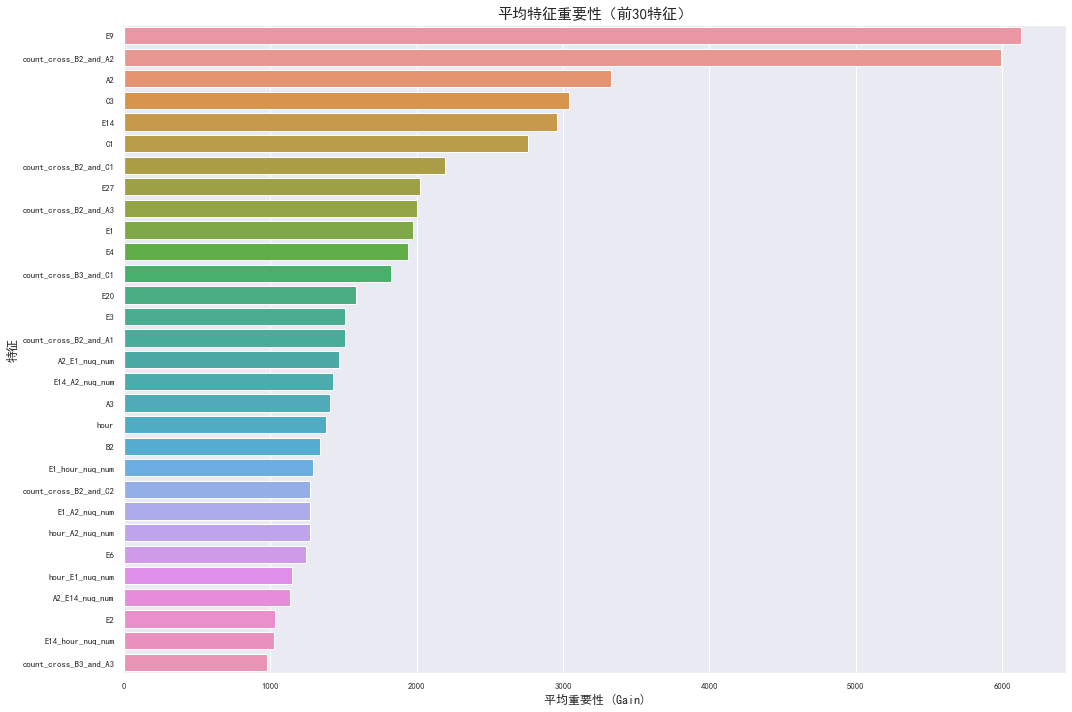

In [7]:
# 4. 特征重要性可视化
def plot_feature_importance(models, feature_names, top_n=30, figsize=(15, 10)):
    # 基模型特征重要性比较
    plt.figure(figsize=figsize)
    all_importance = []
    
    for i, model in enumerate(models):
        importance = model.feature_importance(importance_type='gain')
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance,
            'model': f'模型 {i+1}'
        })
        all_importance.append(feat_imp)
    
    all_importance = pd.concat(all_importance)
    top_features = all_importance.groupby('feature')['importance'].mean().nlargest(top_n).index
    top_imp = all_importance[all_importance['feature'].isin(top_features)]
    
    sns.barplot(x='importance', y='feature', hue='model', data=top_imp)
    plt.title(f'各模型特征重要性对比（前{top_n}特征）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 平均特征重要性
    plt.figure(figsize=figsize)
    mean_imp = all_importance.groupby('feature')['importance'].mean().reset_index()
    mean_imp = mean_imp.sort_values('importance', ascending=False).head(top_n)
    sns.barplot(x='importance', y='feature', data=mean_imp)
    plt.title(f'平均特征重要性（前{top_n}特征）', fontsize=15)
    plt.xlabel('平均重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_feature_importance(models, features)

In [8]:
# 5. 投票预测函数
def voting_predict(models, X, voting_type='soft'):
    """
    投票预测
    voting_type: 'soft'为概率加权平均, 'hard'为多数表决
    """
    if voting_type == 'hard':
        # 硬投票：取多数类
        predictions = []
        for model in models:
            pred_proba = model.predict(X, num_iteration=model.best_iteration)
            predictions.append((pred_proba >= 0.5).astype(int))
        
        predictions = np.array(predictions).T
        final_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)
        return final_pred
    else:
        # 软投票：概率平均值
        all_preds = []
        for model in models:
            pred = model.predict(X, num_iteration=model.best_iteration)
            all_preds.append(pred)
        
        return np.mean(all_preds, axis=0)


交叉验证评估投票模型...
投票模型平均AUC: 0.7898 ± 0.0273
投票模型平均KS: 0.4411 ± 0.0469
投票模型平均最佳F1: 0.4651 ± 0.0254


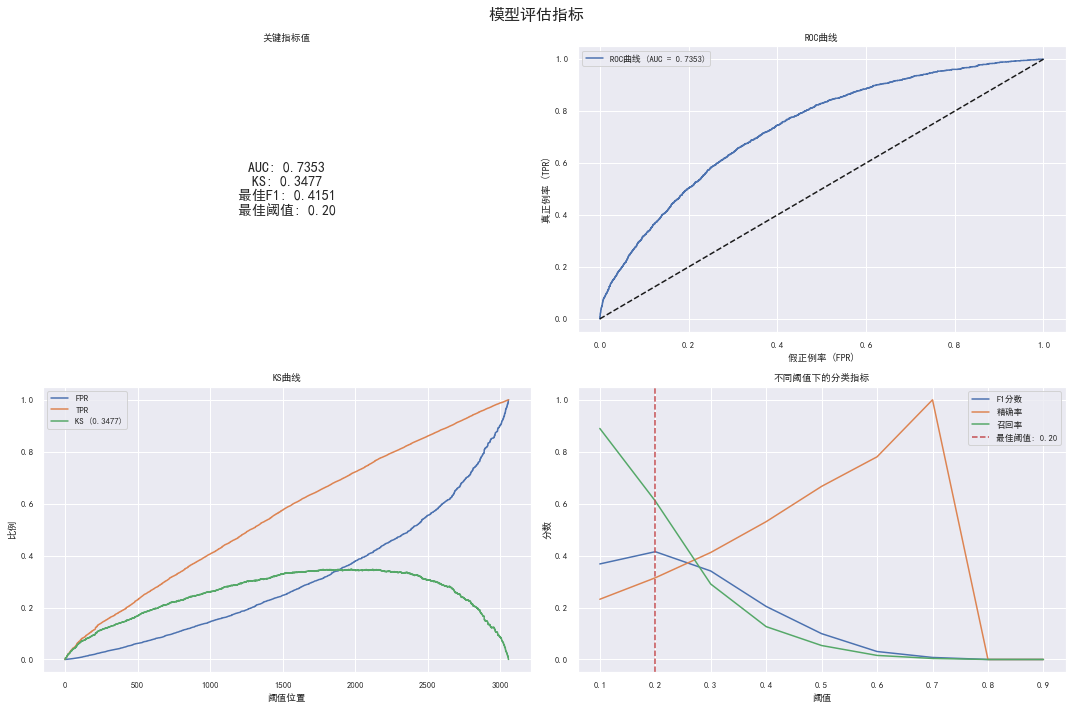

In [9]:
# 6. 模型评估与可视化
def calculate_metrics(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc, 'ks': ks, 'best_f1': best_f1, 
        'best_threshold': best_threshold, 'thresholds': thresholds,
        'f1_scores': f1_scores, 'precision_scores': precision_scores,
        'recall_scores': recall_scores, 'fpr': fpr, 'tpr': tpr
    }

def plot_metrics(metrics, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 1. 关键指标值
    ax1 = axes[0, 0]
    metrics_text = (f"AUC: {metrics['auc']:.4f}\n"
                   f"KS: {metrics['ks']:.4f}\n"
                   f"最佳F1: {metrics['best_f1']:.4f}\n"
                   f"最佳阈值: {metrics['best_threshold']:.2f}")
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # 2. ROC曲线
    ax2 = axes[0, 1]
    ax2.plot(metrics['fpr'], metrics['tpr'], label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # 3. KS曲线
    ax3 = axes[1, 0]
    ax3.plot(metrics['fpr'], label='FPR')
    ax3.plot(metrics['tpr'], label='TPR')
    ax3.plot(metrics['tpr'] - metrics['fpr'], label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值位置')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 4. 阈值对指标的影响
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', 
                label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 交叉验证评估投票模型
print("\n交叉验证评估投票模型...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_auc_scores = []
final_ks_scores = []
final_f1_scores = []

# 保存最后一折结果用于可视化
y_val = None
y_pred_proba = None
fold_metrics = None

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    if isinstance(train_x, pd.DataFrame):
        X_val = train_x.iloc[val_idx]
    else:
        X_val = train_x[val_idx]
    
    # 投票预测
    val_preds = voting_predict(models, X_val)
    
    # 计算指标
    metrics = calculate_metrics(train_y[val_idx], val_preds)
    
    final_auc_scores.append(metrics['auc'])
    final_ks_scores.append(metrics['ks'])
    final_f1_scores.append(metrics['best_f1'])
    
    # 保存最后一折结果
    if fold == kf.n_splits - 1:
        y_val = train_y[val_idx]
        y_pred_proba = val_preds
        fold_metrics = metrics

print(f"投票模型平均AUC: {np.mean(final_auc_scores):.4f} ± {np.std(final_auc_scores):.4f}")
print(f"投票模型平均KS: {np.mean(final_ks_scores):.4f} ± {np.std(final_ks_scores):.4f}")
print(f"投票模型平均最佳F1: {np.mean(final_f1_scores):.4f} ± {np.std(final_f1_scores):.4f}")

# 绘制评估指标可视化
plot_metrics(fold_metrics)

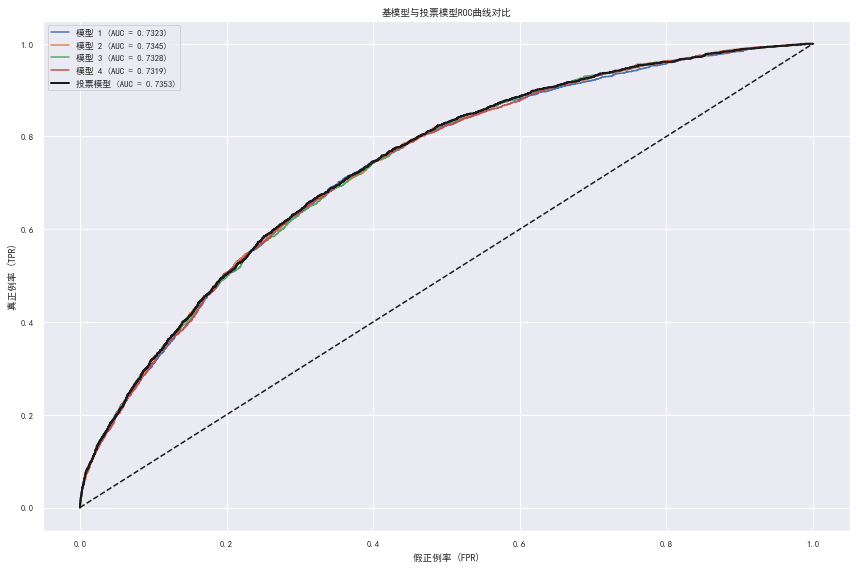


保存模型...
模型已保存为 voting_ensemble_model.pkl


In [10]:

# 7. 基模型性能对比可视化
def plot_base_model_comparison(models, X_val, y_val, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    
    # 各模型ROC曲线对比
    for i, model in enumerate(models):
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        fpr, tpr, _ = roc_curve(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)
        plt.plot(fpr, tpr, label=f'模型 {i+1} (AUC = {auc:.4f})')
    
    # 投票模型ROC曲线
    voting_pred = voting_predict(models, X_val)
    fpr_voting, tpr_voting, _ = roc_curve(y_val, voting_pred)
    auc_voting = roc_auc_score(y_val, voting_pred)
    plt.plot(fpr_voting, tpr_voting, 'k-', linewidth=2, 
             label=f'投票模型 (AUC = {auc_voting:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('假正例率 (FPR)')
    plt.ylabel('真正例率 (TPR)')
    plt.title('基模型与投票模型ROC曲线对比')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 绘制基模型与投票模型对比
plot_base_model_comparison(models, X_val, y_val)

# 8. 保存模型
print("\n保存模型...")
voting_model = {
    'base_models': models,
    'param_sets': param_sets
}

with open('./models/voting_ensemble_model.pkl', 'wb') as f:
    pickle.dump(voting_model, f)

print("模型已保存为 voting_ensemble_model.pkl")

In [17]:
# 9. 加载模型并预测
def predict_with_voting_model(model_path, X, voting_type='soft'):
    with open(model_path, 'rb') as f:
        voting_model = pickle.load(f)
    
    base_models = voting_model['base_models']
    return voting_predict(base_models, X, voting_type)

# 生成测试集预测结果
test_predictions = predict_with_voting_model('./models/voting_ensemble_model.pkl', test_x)
print("\n测试集预测结果示例:", test_predictions[:10])

# 生成提交文件
sub['label'] = test_predictions
sub.to_csv('./sub/voting_ensemble_submission.csv', index=False)
print("提交文件已保存为 voting_ensemble_submission.csv")


测试集预测结果示例: [0.25812638 0.18556609 0.24397782 0.36455758 0.2521742  0.07115726
 0.15907382 0.1984006  0.41927533 0.26058774]
提交文件已保存为 voting_ensemble_submission.csv
